# Create Hexagons

#### !!! As this notebook uses h3 package it will NOT WORK ON WINDOWS !!!

This notebook creates hexagons lying above the bounding boxes of the city Dresden. For spatial analysis these hexagons are very helpful.

### What is done?
1. Load GeoJSON of Dresdens bounding box
2. Polyfill region of Dresden with Hexagons by given resolution
3. Plot and save the hexagons in a dataframe and csv
4. Match corresponding hexagons to start and endpoints of trips
5. Save them into csv file chunks
    - This has to be done because the file is too big to be uplaoded to Github
    - But as h3 package is not working on Windows, we have to upload these files so everyone has these information
    - The next notebook (03_MergeHexagonChunks) can then be run on Windows
    - It loads the chunks and merges them again, creating a Trips_Hexagons.csv (which is on gitignore)

### Input

- data/output/Trips.csv
- data/input/dresden_bounding_box.geojson

### Output
- data/output/hexagons-dresden.csv
- data/output/trips-hexagons/trips-hexagons-{id}.csv
    - (Multiple chunkfiles, each with antoher number as id)
    
---------------------------------------------------------

## 0. Pre-Installations of packages
Copy one of these lines into the next cell. Beware: pip does not like comments so paste it, run the cell and delete it again!
- pip install geopandas
- pip install h3
- pip install matplotlib
- pip install descartes

In [1]:
import pandas as pd
import geopandas
import os
import json
import numpy as np
from h3 import h3
from shapely.geometry import shape
import matplotlib.pyplot as plt

In [2]:
path_trips=os.path.join(os.getcwd(), '..', 'data', 'output', 'Trips.csv')
path_output=os.path.join(os.getcwd(), '..', 'data', 'output')
path_geo =os.path.join(os.getcwd(), '..', 'data', 'input', 'geodata', 'dresden_bounding_box.geojson')

print("Trips path:", path_trips)
print("Output path:", path_output)
print("GeoJSON path:", path_geo)

Trips path: /home/jovyan/work/notebooks/../data/output/Trips.csv
Output path: /home/jovyan/work/notebooks/../data/output
GeoJSON path: /home/jovyan/work/notebooks/../data/input/geodata/dresden_bounding_box.geojson


## 1. Load GeoJSON of Dresdens bounding box
Use Geopandas to read geojson file

In [3]:
city_bounding_box = geopandas.read_file(path_geo)
city_bounding_box_json_string = city_bounding_box.to_json()
city_bounding_box_json = json.loads(city_bounding_box_json_string)
city_bounding_box_poly = city_bounding_box_json["features"][0]

In [4]:
# Valid GeoJSON object
city_bounding_box_poly["geometry"]

{'type': 'Polygon',
 'coordinates': [[[13.746466, 51.178629],
   [13.964722, 51.06278],
   [13.815186, 50.974527],
   [13.572688, 51.0637],
   [13.746466, 51.178629]]]}

## 2. Polyfill region of Dresden with Hexagons by given resolution

In [5]:
# Computing hexagons for a given polygon
polygon_obj = city_bounding_box_poly["geometry"] # your geo json object

H3_HEXAGON_RESOLUTION_SMALL = 7
hexagons_small = h3.polyfill(polygon_obj, res = H3_HEXAGON_RESOLUTION_SMALL, geo_json_conformant = True)
H3_HEXAGON_RESOLUTION_BIG = 6
hexagons_big = h3.polyfill(polygon_obj, res = H3_HEXAGON_RESOLUTION_BIG, geo_json_conformant = True)

In [6]:
# Returns only the index of each hexagon, not the geometries
print("SMALL HEXAGONS:")
print(hexagons_small)
print()
print("BIG HEXAGONS:")
print(hexagons_big)

SMALL HEXAGONS:
{'871f1b46affffff', '871f1b465ffffff', '871f1b09dffffff', '871f1b462ffffff', '871f1b541ffffff', '871f1b09cffffff', '871f1b09effffff', '871f1b09affffff', '871f1b0b0ffffff', '871f1b466ffffff', '871f1b551ffffff', '871f1b54affffff', '871f1b54dffffff', '871f1b095ffffff', '871f1b468ffffff', '871f1b555ffffff', '871f1b569ffffff', '871f1b091ffffff', '871f1b460ffffff', '871f1b099ffffff', '871f1b0b5ffffff', '871f1b568ffffff', '871f1b090ffffff', '871f1b55dffffff', '871f1b0b1ffffff', '871f1b54cffffff', '871f1b56bffffff', '871f1b19bffffff', '871f1b461ffffff', '871f1b0b4ffffff', '871f1b542ffffff', '871f1b545ffffff', '871f1b19affffff', '871f1b0b3ffffff', '871f1b558ffffff', '871f1b19effffff', '871f1b549ffffff', '871f1b094ffffff', '871f1b092ffffff', '871f1b086ffffff', '871f1b080ffffff', '871f1b0b6ffffff', '871f1b46bffffff', '871f1b56dffffff', '871f1b46dffffff', '871f1b096ffffff', '871f1b464ffffff', '871f1b469ffffff', '871f1b54effffff', '871f1b083ffffff', '871f1b55cffffff', '871f1b559ffff

## 3. Plot and save the hexagons in a dataframe and csv
### 3.1. Convert H3 Indexes to Geometry Objects

In [7]:
# Create geo data frame for small hexagons (resolution = 7)
df_hexagons_small = geopandas.GeoDataFrame(list(hexagons_small), columns=['h3_hex_small_id'])
df_hexagons_small['geometry'] = df_hexagons_small[(df_hexagons_small['h3_hex_small_id'].notna())].apply(lambda row: shape({"type": "Polygon",
                                           "coordinates": [h3.h3_to_geo_boundary(row["h3_hex_small_id"], geo_json=True)],
                                           "properties": ""
                                           }), axis=1)
df_hexagons_small = df_hexagons_small.set_crs('EPSG:4326')

# Create geo data frame for big hexagons (resolution = 6)
df_hexagons_big = geopandas.GeoDataFrame(list(hexagons_big), columns=['h3_hex_big_id'])
df_hexagons_big['geometry'] = df_hexagons_big[(df_hexagons_big['h3_hex_big_id'].notna())].apply(lambda row: shape({"type": "Polygon",
                                           "coordinates": [h3.h3_to_geo_boundary(row["h3_hex_big_id"], geo_json=True)],
                                           "properties": ""
                                           }), axis=1)
df_hexagons_big = df_hexagons_big.set_crs('EPSG:4326')

### 3.2. Simply plot hexagons and print dataframe

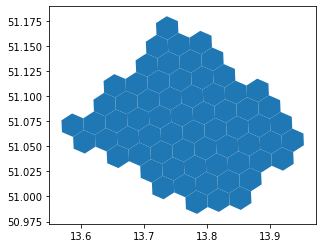

In [8]:
df_hexagons_small.plot()

In [9]:
df_hexagons_small

,h3_hex_small_id,geometry
0,871f1b46affffff,"POLYGON ((13.79965 51.00120, 13.80044 50.98948..."
1,871f1b465ffffff,"POLYGON ((13.74407 51.05094, 13.74487 51.03922..."
2,871f1b09dffffff,"POLYGON ((13.89904 51.07748, 13.89982 51.06576..."
3,871f1b462ffffff,"POLYGON ((13.71180 51.01377, 13.71261 51.00205..."
4,871f1b541ffffff,"POLYGON ((13.65373 51.09857, 13.65454 51.08686..."
...,...,...
61,871f1b548ffffff,"POLYGON ((13.70698 51.08406, 13.70778 51.07235..."
62,871f1b0b2ffffff,"POLYGON ((13.75783 51.10465, 13.75863 51.09294..."
63,871f1b093ffffff,"POLYGON ((13.81345 51.05495, 13.81423 51.04323..."
64,871f1b082ffffff,"POLYGON ((13.84580 51.09208, 13.84658 51.08037..."


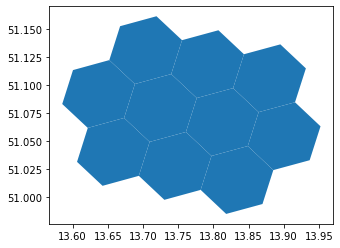

In [10]:
df_hexagons_big.plot()

In [11]:
df_hexagons_big

,h3_hex_big_id,geometry
0,861f1b55fffffff,"POLYGON ((13.62149 51.06140, 13.60621 51.03109..."
1,861f1b09fffffff,"POLYGON ((13.86433 51.07550, 13.84893 51.04522..."
2,861f1b547ffffff,"POLYGON ((13.60046 51.11305, 13.58518 51.08276..."
3,861f1b54fffffff,"POLYGON ((13.68842 51.10061, 13.67310 51.07032..."
4,861f1b467ffffff,"POLYGON ((13.70939 51.04892, 13.69407 51.01862..."
5,861f1b087ffffff,"POLYGON ((13.84345 51.12721, 13.82805 51.09694..."
6,861f1b56fffffff,"POLYGON ((13.66742 51.15224, 13.65210 51.12198..."
7,861f1b46fffffff,"POLYGON ((13.79729 51.03637, 13.78193 51.00607..."
8,861f1b097ffffff,"POLYGON ((13.77638 51.08809, 13.76102 51.05780..."
9,861f1b0b7ffffff,"POLYGON ((13.75544 51.13976, 13.74008 51.10950..."


### 3.3. Save hexagons as csv

In [12]:
df_hexagons_small.to_csv(os.path.join(path_output, "hexagons-small-dresden.csv"))

In [13]:
df_hexagons_big.to_csv(os.path.join(path_output, "hexagons-big-dresden.csv"))

## 4. Match corresponding hexagons to start and endpoints of trips

In [14]:
df_trips = pd.read_csv(path_trips, index_col="Unnamed: 0")
df_trips.head()

,p_bike_racks_start,p_spot_start,p_booked_bikes_start,p_place_type_start,datetime_start,b_number_start,p_uid_start,p_bikes_start,p_lat_start,b_electric_lock_start,...,day_of_year_end,season,weekend,booking_date_start,trip_duration,idle_time,24_sum,6_sum,2_sum,1_sum
0,0,False,0,12,2019-01-20 00:00:00,93771,12095573,1,51.071262,False,...,20,1,True,2019-01-20 00:00:00,28.0,0.0,265,36,19,8
1,0,True,0,0,2019-01-20 00:05:00,93576,10299640,5,51.038210,False,...,20,1,True,2019-01-20 00:00:00,10.0,0.0,265,33,17,17
2,0,True,0,0,2019-01-20 00:07:00,93440,10299584,1,51.042570,True,...,20,1,True,2019-01-20 00:00:00,26.0,0.0,265,33,17,17
3,0,False,0,12,2019-01-20 00:07:00,93322,12098234,1,51.041798,False,...,20,1,True,2019-01-20 00:00:00,2.0,0.0,265,33,17,17
4,0,True,0,0,2019-01-20 00:07:00,93585,264575,5,51.071740,False,...,20,1,True,2019-01-20 00:00:00,28.0,0.0,265,33,17,17


In [15]:
df_trips.columns

Index(['p_bike_racks_start', 'p_spot_start', 'p_booked_bikes_start',
       'p_place_type_start', 'datetime_start', 'b_number_start', 'p_uid_start',
       'p_bikes_start', 'p_lat_start', 'b_electric_lock_start',
       'b_bike_type_start', 'p_name_start', 'p_free_racks_start',
       'b_lock_types_start', 'p_number_start', 'p_lng_start',
       'b_boardcomputer_start', 'p_maintenance_start', 'p_bike_racks_end',
       'p_spot_end', 'p_booked_bikes_end', 'p_place_type_end', 'datetime_end',
       'p_uid_end', 'p_bikes_end', 'p_lat_end', 'p_name_end',
       'p_free_racks_end', 'p_number_end', 'p_lng_end', 'p_maintenance_end',
       'air_deg', 'air_hum', 'rain_mm', 'rain_yn', 'sun_hour', 'wind_ms',
       'month_start', 'month_end', 'day_start', 'day_end', 'day_of_week_start',
       'day_of_week_end', 'hour_start', 'hour_end', 'day_of_year_start',
       'day_of_year_end', 'season', 'weekend', 'booking_date_start',
       'trip_duration', 'idle_time', '24_sum', '6_sum', '2_sum', '1_su

In [16]:
# Get the hexagon for a data point
# Assume we have a dataframe with a column for latitude and longitude representing "point data".

# Add hex ids for small hexagons and for start and end point
df_trips["h3_hex_small_id_start"] = df_trips.apply(lambda row: h3.geo_to_h3(row["p_lat_start"], row["p_lng_start"], H3_HEXAGON_RESOLUTION_SMALL) if (row['p_lat_start'] and row['p_lng_start']) else 0, axis=1)
df_trips["h3_hex_small_id_end"] = df_trips.apply(lambda row: h3.geo_to_h3(row["p_lat_end"], row["p_lng_end"], H3_HEXAGON_RESOLUTION_SMALL) if (row['p_lat_end'] and row['p_lng_end']) else 0, axis=1)

# Add hex ids for big hexagons and for start and end point
df_trips["h3_hex_big_id_start"] = df_trips.apply(lambda row: h3.geo_to_h3(row["p_lat_start"], row["p_lng_start"], H3_HEXAGON_RESOLUTION_BIG) if (row['p_lat_start'] and row['p_lng_start']) else 0, axis=1)
df_trips["h3_hex_big_id_end"] = df_trips.apply(lambda row: h3.geo_to_h3(row["p_lat_end"], row["p_lng_end"], H3_HEXAGON_RESOLUTION_BIG) if (row['p_lat_end'] and row['p_lng_end']) else 0, axis=1)
df_trips.head()

,p_bike_racks_start,p_spot_start,p_booked_bikes_start,p_place_type_start,datetime_start,b_number_start,p_uid_start,p_bikes_start,p_lat_start,b_electric_lock_start,...,trip_duration,idle_time,24_sum,6_sum,2_sum,1_sum,h3_hex_small_id_start,h3_hex_small_id_end,h3_hex_big_id_start,h3_hex_big_id_end
0,0,False,0,12,2019-01-20 00:00:00,93771,12095573,1,51.071262,False,...,28.0,0.0,265,36,19,8,871f1b54bffffff,871f1b559ffffff,861f1b54fffffff,861f1b55fffffff
1,0,True,0,0,2019-01-20 00:05:00,93576,10299640,5,51.038210,False,...,10.0,0.0,265,33,17,17,871f1b460ffffff,871f1b464ffffff,861f1b467ffffff,861f1b467ffffff
2,0,True,0,0,2019-01-20 00:07:00,93440,10299584,1,51.042570,True,...,26.0,0.0,265,33,17,17,871f1b559ffffff,871f1b460ffffff,861f1b55fffffff,861f1b467ffffff
3,0,False,0,12,2019-01-20 00:07:00,93322,12098234,1,51.041798,False,...,2.0,0.0,265,33,17,17,871f1b559ffffff,871f1b559ffffff,861f1b55fffffff,861f1b55fffffff
4,0,True,0,0,2019-01-20 00:07:00,93585,264575,5,51.071740,False,...,28.0,0.0,265,33,17,17,871f1b54bffffff,871f1b54bffffff,861f1b54fffffff,861f1b54fffffff


## 5. Save them into csv file chunks
- This has to be done because the file is too big to be uplaoded to Github
- But as h3 package is not working on Windows, we have to upload these files so everyone has these information
- The next notebook (03_MergeHexagonChunks) can then be run on Windows
- It loads the chunks and merges them again, creating a Trips_Hexagons.csv (which is on gitignore)

In [17]:
# Save as Trips.csv directly
df_trips.to_csv(os.path.join(path_output, "Trips.csv"))

# Into how many chunks do you want to split the dataframe?
number_of_chunks = 5

for id, df_chunk in enumerate(np.array_split(df_trips, number_of_chunks)):
    df_chunk.to_csv(os.path.join(path_output, "trips-hexagons","trips-hexagons-{id}.csv").format(id=id))